In [1]:
import pandas as pd
import os
from matplotlib import pyplot as plt
from datetime import datetime
from tqdm import tqdm
from matplotlib.patches import Rectangle
from datetime import timedelta
from matplotlib.collections import PatchCollection

# 读取文件 pressures.csv

In [2]:
# df = pd.read_excel('./Measurements.xlsx', sheet_name=['Flows(m3_h)'], n_rows=1000)
path18 = './赛题数据/2018_BattLeDIM_Data_v1.1/2018 SCADA (CSV)/'
path19 = './赛题数据/2019_BattLeDIM_Data_v1.0/2019 SCADA (CSV)/'
file = 'Pressures.csv'
df18 = pd.read_csv(os.path.join(path18, file),
                     sep = ';',
                     parse_dates=['Timestamp'],
                     index_col='Timestamp'
                    )
df19 = pd.read_csv(os.path.join(path19, file),
                     sep = ';',
                     parse_dates=['Timestamp'],
                     index_col='Timestamp'
                    )
columns = list(df18.columns)
def comma_to_point(x):
    return float(x.replace(',','.'))
for i in columns:
    df18[i] = df18[i].apply(comma_to_point)

for j in columns:
    df19[j] = df19[j].apply(comma_to_point)
    
df = pd.concat([df18, df19])

# 分解趋势项

In [3]:
freq = 24*12
from statsmodels.tsa.seasonal import seasonal_decompose
def analyse(df):
    freq = 24*12
    decomposition = seasonal_decompose(x=df, model='additive', freq=freq)
    seasonal_day = decomposition.seasonal
    trend_day = decomposition.trend
    resi_day = decomposition.resid

    decomposition2 = seasonal_decompose(x=trend_day.dropna(), model='additive', freq=freq*7)
    seasonal_week = decomposition2.seasonal
    trend_week = decomposition2.trend
    resi_week = decomposition2.resid
    return trend_week

res_list = []

for i in tqdm(columns):
    res_list += [analyse(df[i])]


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:16<00:00,  2.01it/s]


# 读取泄露

In [17]:
leakage_info = pd.read_excel('./WXT_2018-leakages.xlsx',
                            sheet_name='Sheet3')
# leakage_info = pd.read_excel('./total1_result.xlsx',parse_dates=['start','end'])

In [24]:
leakage_info.head(5)

,Leak Pipe,Leak Area,Leak Diameter,Leak Type,Leak Start,Leak End,Peak Time,DMA
0,p257,0.000110,0.011843,incipient_unfix,2018-01-08 13:30:00,2018-12-31 23:55:00,2018-01-25 08:30:00,C
1,p461,0.000357,0.021320,incipient,2018-01-23 04:25:00,2018-04-02 11:40:00,2018-03-27 20:35:00,A
2,p232,0.000318,0.020108,incipient,2018-01-31 02:35:00,2018-02-10 09:20:00,2018-02-03 16:05:00,A
3,p427,0.000065,0.009073,incipient_unfix,2018-02-13 08:25:00,2018-12-31 23:55:00,2018-05-14 19:25:00,A
4,p673,0.000412,0.022916,abrupt,2018-03-05 15:45:00,2018-03-23 10:25:00,2018-03-05 15:45:00,B


# 画出压力与漏点关系

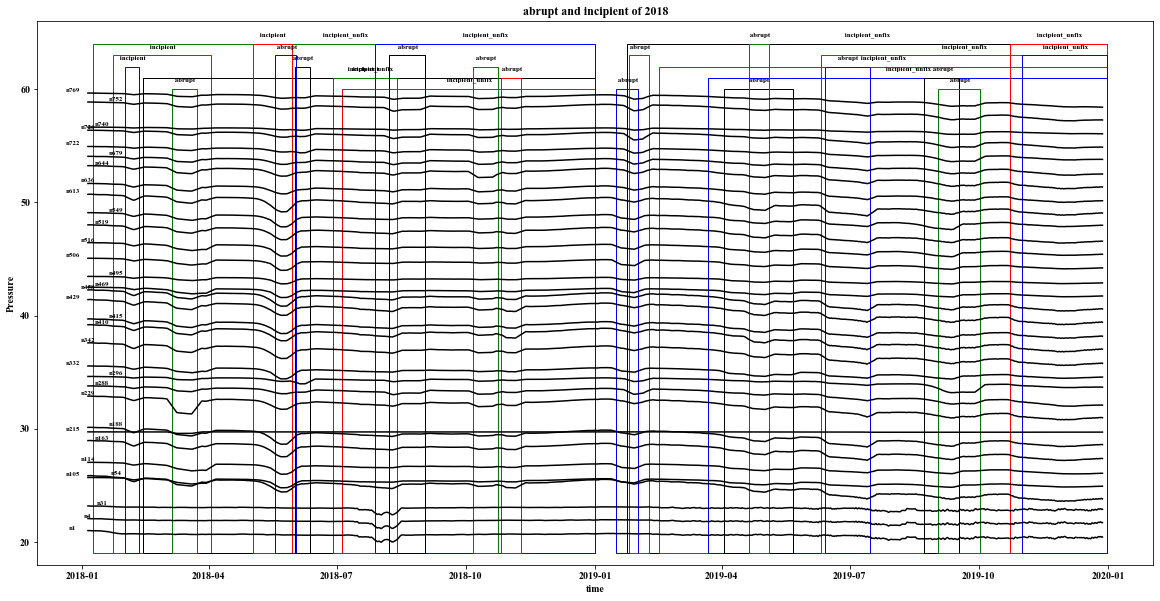

In [25]:
plt.figure(facecolor='w',figsize=(20,10))
x_list = [datetime(2017,12,25), datetime(2018,1,5), datetime(2018,1,15),datetime(2018,1,25)]
for index, i in enumerate(res_list):
    i = i[::4]
    i = i - i.min() + index*1.2 + 20
    plt.plot(i,'black')
    plt.text(x_list[index%4], i.dropna()[0],str(i.name),ha='center', va= 'bottom',fontsize=7)
# plt.legend(columns)
# for i in leakage_time:
#     plt.plot([i,i],[24,60],'red')
# plt.scatter(leakage_time, [df18[leakage_loc[i]][leakage_time[i]] for i in range(0, len(leakage_loc))])
color_list = ['green','red','blue','black']
height_list = [37,36,35,34,33]
ax = plt.gca()
for i in range(0, leakage_info.shape[0]):
    start = leakage_info.iloc[i]['Leak Start']
    timedelta = leakage_info.iloc[i]['Leak End'] - start
    leaktype = leakage_info.iloc[i]['Leak Type']
    ax.add_patch(Rectangle( (start,19), timedelta, 8+height_list[i%5], fill=False, color=color_list[i%4]))
    plt.text(start+timedelta/2, 19+8+height_list[i%5]+0.5, leaktype, ha='center', va= 'bottom',fontsize=7)
ax.set_ylim([18, 66])
plt.xlabel('time')
plt.ylabel('Pressure')
plt.title('abrupt and incipient of 2018')
# plt.savefig('./abrupt and incipient of 2018 2019 vs pressure.png', format='png',dpi=600)
plt.show()

# 找出漏点位置 保存在 posi3.csv

In [149]:
res_list_big = []
for i in range(3, leakage_info.shape[0]):
    
    start_real = leakage_info.iloc[i]['start']
    end_real = leakage_info.iloc[i]['end']
    start = start_real - timedelta(5)
    end = end_real + timedelta(5)
    
    start1  = start_real - timedelta(50)
    end1 = end_real + timedelta(50)
    leaktype = leakage_info.iloc[i]['type']
    loc = leakage_info.iloc[i]['loc']
    if leakage_info.iloc[i]['type'] != 'Incipient':
        helplist = []
        for j in res_list:    
#             j = (j - j.rolling(12*2, center=True).mean())
            if j.name not in ['n1','n4','n31','n54','n410','n429']:
                j = j.dropna()
                helplist += [[j.name, abs(j[start:end].mean()-j[start1:end1].mean())/j[start1:end1].mean()]]
        helpdf = pd.DataFrame(helplist).sort_values(1,ascending=False).head(10)
        res_list_big += [[start, end, leaktype, loc] + list(helpdf[0])]
res_df = pd.DataFrame(res_list_big)

In [52]:
res_df.to_csv('./posi3.csv')

# 残差与漏点关系

In [15]:
useless_list = ['n54','n410','n458','n429']
C = ['n1', 'n4', 'n31']
B = ['n215', 'n219']

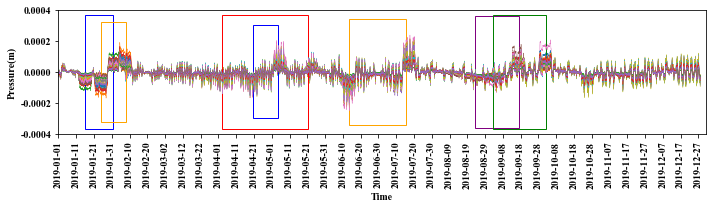

In [23]:
plt.figure(facecolor='w',figsize=(10,3))
for index, i in enumerate(res_list):
#     i = i[::4]
    if i.name not in (useless_list+C+B):
#     if i.name in B:
        i = (i - i.rolling(12*2, center=True).mean())#.abs() # + index*1.2 + 20
        plt.plot(i.tail(int(df.shape[0]/2)), linewidth=0.4)
#     plt.text(x_list[index%4], i.dropna()[0],str(i.name),ha='center', va= 'bottom',fontsize=7)
color_list = ['green','red','blue','black','orange','purple']
height_list = [0.0006,0.00064,0.00068,0.00072,0.00074]
ax = plt.gca()
for i in range(0, leakage_info.shape[0]):
    start = leakage_info.iloc[i]['Leak Start']
    timedelta = leakage_info.iloc[i]['Leak End'] - start
    leaktype = leakage_info.iloc[i]['Leak Type']
    DMA = leakage_info.iloc[i]['DMA']
    if leaktype == ' abrupt':
#     if DMA not in ['B','C']:
        ax.add_patch(Rectangle( (start,-height_list[i%5]/2), 
                               timedelta, height_list[i%5], 
                               fill=False, color=color_list[i%6]))
#     plt.text(start+timedelta/2, 19+8+height_list[i%5]+0.5, leaktype, ha='center', va= 'bottom',fontsize=7)
import pylab as pl
import matplotlib.ticker as ticker
ax = plt.gca()
pl.xticks(rotation=90)
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
# ax.yaxis.set_major_locator(ticker.MultipleLocator(5)) # 155-
ax.set_ylim([-0.0004, 0.0004])
plt.xlabel('Time')
plt.ylabel('Pressure(m)')
plt.xlim([datetime(2019,1,1),datetime(2019,12,31)])
# plt.title('Abrupt of 2019 in DMA-B')
plt.tight_layout()
plt.savefig('./abrupt and incipient of 2019 vs pressure rolled DMA-B.png', format='png',dpi=2000)
plt.show()

# PCA与漏点

# VAR与漏点

# 压降图

In [5]:
import matplotlib as mpl

mpl.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Times New Roman'],
    })  # 设置全局字体
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

In [4]:
tb_c = pd.read_excel(os.path.join('./赛题数据', 'hydaulic_model_sensornode_p.xlsx'),
                    parse_dates=['Timestamp'],
                    index_col='Timestamp')

In [6]:
tbhelper = pd.DataFrame(index=df.index, columns=tb_c.columns)
# tbhelper.join(tb_c, on='Timestamp')

In [7]:
tbhelper.update(tb_c)
for i in range(0,104):
    tbhelper.iloc[i*12*24*7:(i+1)*12*24*7] = tbhelper.iloc[0:12*24*7].values

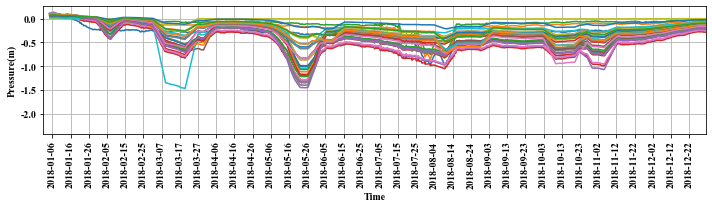

In [13]:
import pylab as pl
import matplotlib.ticker as ticker
plt.figure(figsize=(10,3),facecolor='w')
# plt.plot((df-tb_c).head(12*24*7))
plt.plot((df-tbhelper).rolling(12*24*7, center=True).mean().head(7*12*24*300))

ax = plt.gca()
pl.xticks(rotation=90)
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
plt.grid() 
# ax.yaxis.set_major_locator(ticker.MultipleLocator(5)) # 155-
plt.xlabel('Time')
plt.ylabel('Pressure(m)')
plt.xlim([datetime(2018,1,1),datetime(2018,12,31)])
plt.tight_layout()
plt.savefig('./pressure real-simulated.png',format='png',dpi=1000)